In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import torch

# **EDA**

## Tải dữ liệu và làm sạch dữ liệu với pandas

In [3]:
# Đọc dữ liệu
df = pd.read_csv('/content/drive/MyDrive/MCI Test/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1")
df.columns = ["target", "ids", "date", "flag", "user", "text"]
df

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1599999 non-null  int64 
 1   ids     1599999 non-null  int64 
 2   date    1599999 non-null  object
 3   flag    1599999 non-null  object
 4   user    1599999 non-null  object
 5   text    1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
df['target'].value_counts()

,count
target,
4,800000
0,799999


In [6]:
# Chuyển đổi nhãn cảm xúc (4 -> 1, 0 -> 0)
# Chuyển 0 thành 0 (Negative), 4 thành 1 (Positive)
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

df['target'].value_counts()

,count
target,
1,800000
0,799999


## Phân tích sơ bộ: số lượng mẫu, phân phối nhãn, dữ liệu trùng lặp, dữ liệu bị thiếu.


In [7]:
# Xóa cột không cần thiết
df.drop(columns=["ids", "date", "flag", "user"], inplace=True)

In [8]:
# Xóa dữ liệu không cần thiết và trùng lặp
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [9]:
# Kiểm tra phân phối dữ liệu
print("Số lượng mẫu:", df.shape[0])
print("Phân phối nhãn:")
print(df["target"].value_counts())

Số lượng mẫu: 1583690
Phân phối nhãn:
target
1    793506
0    790184
Name: count, dtype: int64


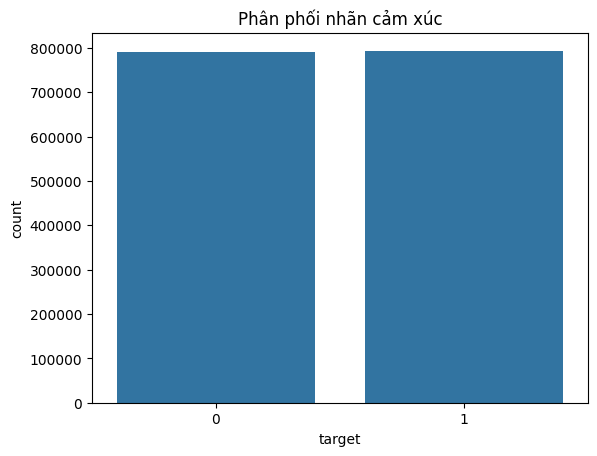

In [10]:
# Biểu đồ phân phối nhãn
sns.countplot(x=df["target"])
plt.title("Phân phối nhãn cảm xúc")
plt.show()

# **FINE-TUNE MÔ HÌNH LLM**

## Chia tập dữ liệu thành tập train/test

In [11]:
#from sklearn.model_selection import train_test_split

# Chia dữ liệu thành 80% train, 20% test
#train_texts, val_texts, train_labels, val_labels = train_test_split(df["text"].tolist(), df["target"].tolist(), test_size=0.2, random_state=42)

## Tiền xử lý văn bản với Tokenizer

In [12]:
import re
from transformers import BertTokenizer
import torch

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Clean text function
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^A-Za-z\s]", "", text)  # Remove special characters
    return text.lower().strip()

# Apply cleaning
df["text"] = df["text"].apply(clean_text)

# Tokenize and encode text using BERT tokenizer
def tokenize_data(texts, labels, max_len=128):
    encodings = tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=max_len,
        return_tensors="pt",
    )
    labels = torch.tensor(labels.values)
    return encodings, labels

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["target"], test_size=0.2, random_state=42
)

train_encodings, train_labels = tokenize_data(train_texts, train_labels)
test_encodings, test_labels = tokenize_data(test_texts, test_labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Tạo class Dataset

## Load mô hình BERT

In [14]:
import torch
from transformers import BertForSequenceClassification

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = model.to(device)  # Move the model to the appropriate device

Using device: cpu


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Huấn luyện mô hình

In [15]:
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from tqdm import tqdm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]

        return item

# Create DataLoaders
train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Move model to appropriate device
model = model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        # Move data to appropriate device
        batch = {key: val.to(device) for key, val in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader)}")


Using device: cpu


Epoch 1:   0%|          | 2/79185 [00:42<466:30:40, 21.21s/it, loss=0.673]


KeyboardInterrupt: 

# **Đánh giá mô hình**

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Evaluation loop
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        # Move batch data to the appropriate device
        batch = {key: val.to(device) for key, val in batch.items()}

        # Forward pass
        outputs = model(**batch)

        # Predictions and labels
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Move predictions to CPU for metrics
        labels = batch["labels"].cpu().numpy()  # Move labels to CPU

        all_preds.extend(preds)
        all_labels.extend(labels)

# Generate the classification report
print(classification_report(all_labels, all_preds))
# confusion metrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
model.save_pretrained("sentiment_model")
tokenizer.save_pretrained("sentiment_model")